In [1]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

results_path = "results/final"

In [2]:
model_order = ["mlp", "cnn", "lstm"]
backend_order = ["jax", "jax-keras", "tf-keras", "torch-keras", "torch"]
precision_order = ["fp32", "fp16", "bf16", "mixed_fp16", "mixed_bf16"]

In [3]:
# Dictionary to store the data
results = {}

# Iterate through the seed folders
for seed in os.listdir(results_path):
    seed_path = os.path.join(results_path, seed)
    
    # Check that it is a directory
    if os.path.isdir(seed_path):
        # Iterate through the model folders inside each seed
        for folder in os.listdir(seed_path):
            folder_path = os.path.join(seed_path, folder)

            if os.path.isdir(folder_path):
                # Extract information from the folder name
                parts = folder.split('_')
                
                timestamp = parts[0]  # contains date+time
                framework = parts[1]
                model = parts[2]
                complexity = parts[3]
                precision = "_".join(parts[4:-1])
                seed = parts[-1]

                # Initialize structure if it doesn't exist
                if model not in results:
                    results[model] = {}

                if framework not in results[model]:
                    results[model][framework] = {}

                if precision not in results[model][framework]:
                    results[model][framework][precision] = {}

                if seed not in results[model][framework][precision]:
                    results[model][framework][precision][seed] = {}
                
                # Load CSVs into DataFrames
                for file in os.listdir(folder_path):
                    if file.endswith(".csv"):
                        csv_path = os.path.join(folder_path, file)
                        csv_name = os.path.splitext(file)[0]  # Name without extension
                        df = pd.read_csv(csv_path)

                        # Save the DataFrame in the structure
                        results[model][framework][precision][seed][csv_name] = df
                    elif (file == "error.txt"):
                        results[model][framework][precision][seed]["error"] = True
                        

# Final structure: {model -> framework -> precision -> seed -> {csv_name -> DataFrame}}

In [4]:
global_metrics_list = []

for model, libraries in results.items():
    for framework, precisions in libraries.items():
        for precision, seeds in precisions.items():
            for seed, data in seeds.items():
                
                if "global_metrics" in data:
                    df = data["global_metrics"].copy()  # Copy the DataFrame to modify it
                    df["training_time"] = df["training_time"] / 60  # Convert time from seconds to minutes
                    df["test_loss"] = data["test"]["loss"][0]
                    global_metrics_list.append(df)
                
global_metrics_df = pd.concat(global_metrics_list, ignore_index=True)
global_metrics_df = global_metrics_df.sort_values(by=["model_type", "model_complexity"])

In [5]:
global_metrics_df.head(5)


,backend,model_type,model_complexity,precision,epochs,batch_size,seed,gpu_ids,definition_time,training_time,testing_time,gpu_2_memory_total,test_loss
0,torch-keras,cnn,simple,mixed_bf16,100,64,42,2,0.304922,13.758905,1.916519,81920.0,0.765928
1,torch-keras,cnn,simple,fp32,100,64,42,2,2.214269,11.697342,1.354060,81920.0,0.772665
2,torch-keras,cnn,simple,bf16,100,64,42,2,1.878635,12.022351,1.385409,81920.0,2.310117
3,torch-keras,cnn,simple,mixed_fp16,100,64,42,2,1.880169,13.799165,1.387449,81920.0,0.778178
4,torch-keras,cnn,simple,fp16,100,64,42,2,1.982023,11.710570,1.334051,81920.0,NaN


/tmp/ipykernel_590915/3544800639.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/3544800639.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/3544800639.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


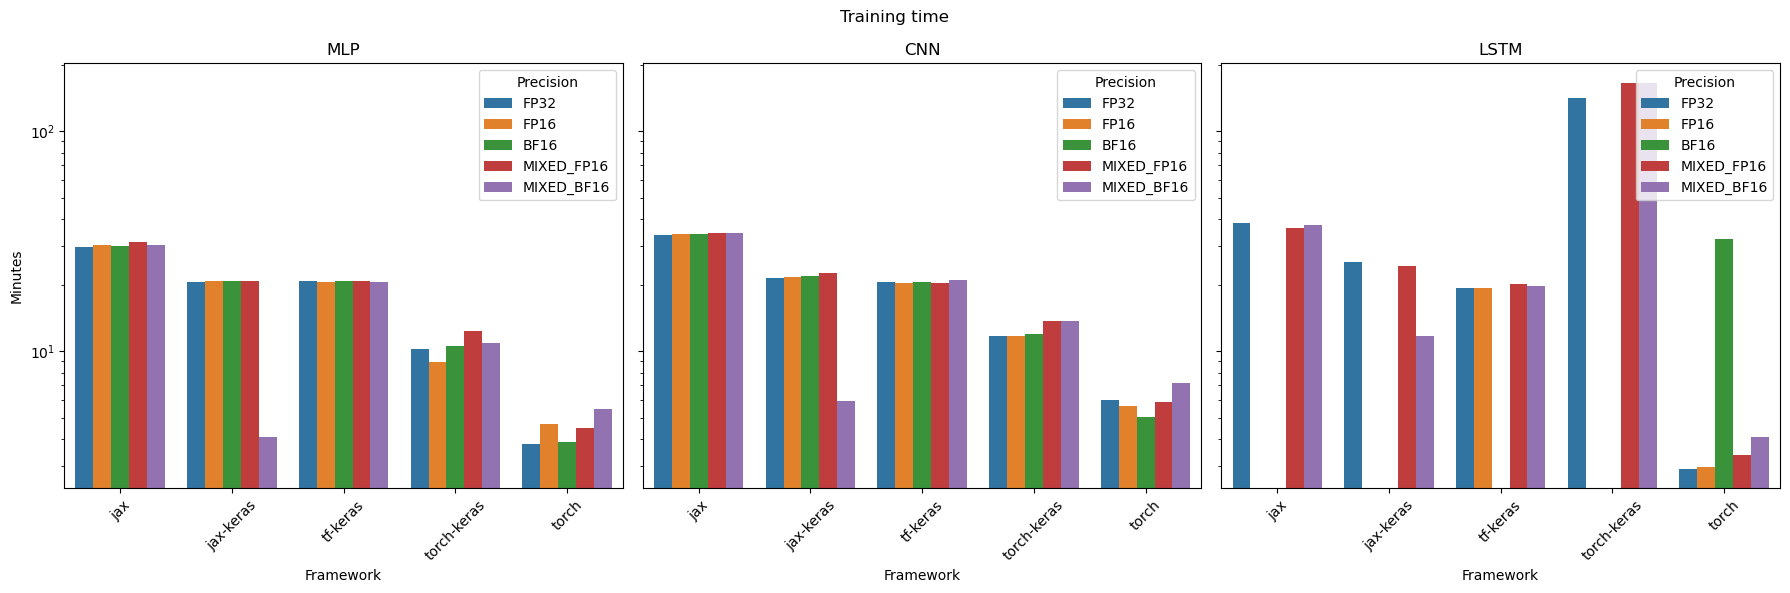

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Training time")

for i, model in enumerate(model_order):
    ax = axes[i]
    model_df = global_metrics_df[global_metrics_df["model_type"] == model]
    
    sns.barplot(
        data=model_df,#[pd.isna(model_df["test_loss"]) == False],
        x="backend",
        y="training_time",
        hue="precision",
        order=backend_order,
        hue_order=precision_order,
        ax=ax
    )
    
    ax.set_title(model.upper())
    ax.set_xlabel("Framework")
    ax.set_ylabel("Minutes" if i == 0 else "")  # Only show y-label on the first plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set(yscale="log")

    legend = ax.legend(title='Precision', loc='upper right')
    for label in legend.get_texts():
        label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

/tmp/ipykernel_590915/905491761.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/905491761.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/905491761.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


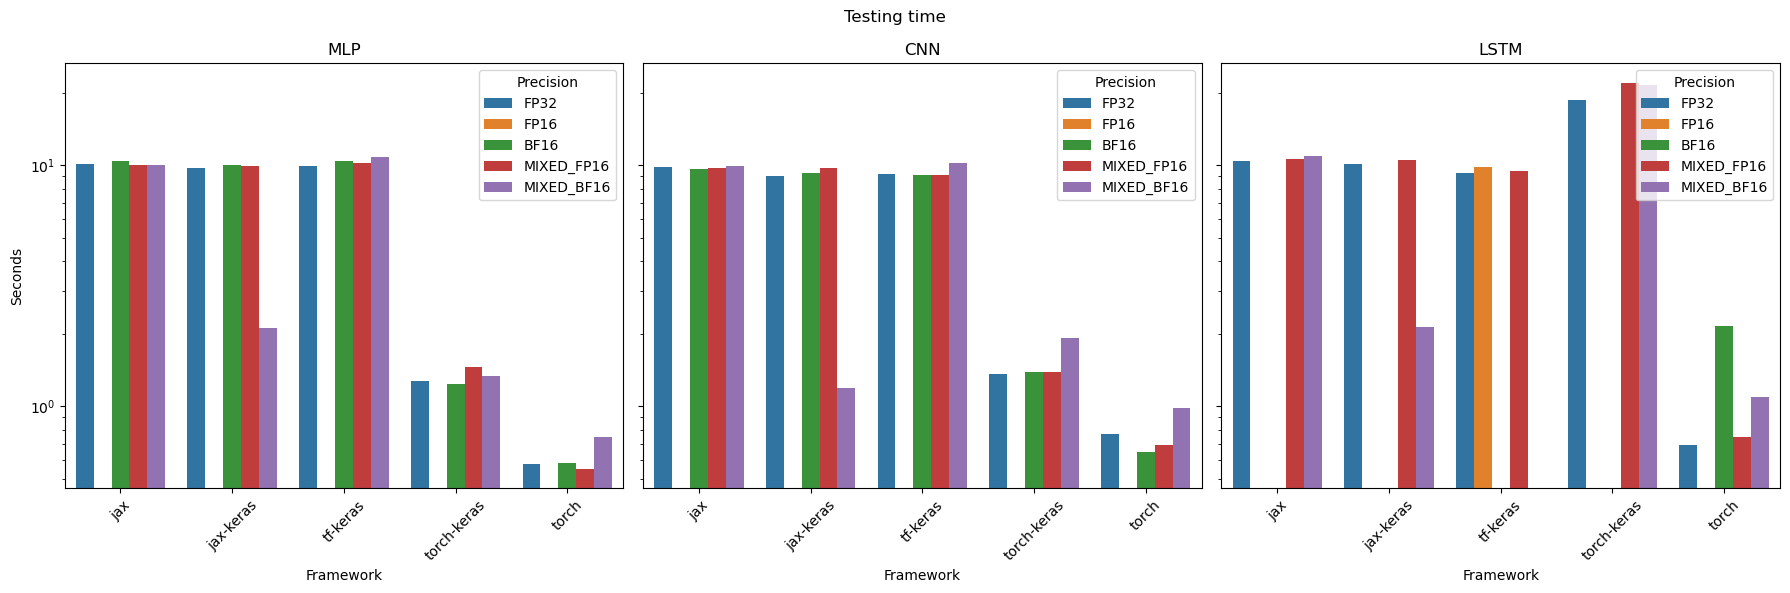

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Testing time")

for i, model in enumerate(model_order):
    ax = axes[i]
    model_df = global_metrics_df[global_metrics_df["model_type"] == model]
    
    sns.barplot(
        data=model_df[pd.isna(model_df["test_loss"]) == False],
        x="backend",
        y="testing_time",
        hue="precision",
        order=backend_order,
        hue_order=precision_order,
        ax=ax
    )
    
    ax.set_title(model.upper())
    ax.set_xlabel("Framework")
    ax.set_ylabel("Seconds" if i == 0 else "")  # Only show y-label on the first plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set(yscale="log")

    legend = ax.legend(title='Precision', loc='upper right')
    for label in legend.get_texts():
        label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

In [ ]:

def get_mean_df(experiments, filename):

    return experiments["42"]

    # List to store the dataFrames of all the seeds of a framework.
    dfs = []

    for seed, files in experiments.items():
        if filename in files:
            dfs.append(files[filename])

    df_concatenado = pd.concat(dfs, axis=0)
    return df_concatenado.groupby(df_concatenado.index).mean()  # Mean row by row


In [9]:
def show_plots(model_type):
    libraries = list(results[model_type].keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"{model_type.upper()} Results", fontsize=20)

    # Generate plots: iterate over each framework
    for i, framework in enumerate(libraries):
        train_samples_df = get_mean_df(results[model_type][framework], "train_samples")
        
        # Plot 1: GPU Utilization vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_utilization", ax=axes[0], label=framework)
        
        # Plot 2: GPU Power vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_power", ax=axes[1], label=framework)

    # Set titles and axis labels
    axes[0].set_title("GPU Usage During Training")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("GPU Usage (%)")

    axes[1].set_title("Instant GPU Power During Training")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Instant Power (W)")

    # Add legends and optional log scale for LSTM
    for i, ax in enumerate(axes.flat):
        ax.legend(title="Framework")
        if model_type == "lstm":
            if i < 3:
                ax.set(xscale="log")
            else:
                ax.set(yscale="log")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


In [8]:
def show_plots(model_type):
    libraries = list(results[model_type].keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"{model_type.upper()} Results", fontsize=20)

    # Generate plots: iterate over each framework
    for i, framework in enumerate(libraries):
        train_samples_df = results[model_type][framework]["fp32"]["42"]["train_samples"]
        
        # Plot 1: GPU Utilization vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_2_utilization", ax=axes[0], label=framework)
        
        # Plot 2: GPU Power vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_2_power", ax=axes[1], label=framework)

    # Set titles and axis labels
    axes[0].set_title("GPU Usage During Training")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("GPU Usage (%)")

    axes[1].set_title("Instant GPU Power During Training")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Instant Power (W)")

    # Add legends and optional log scale for LSTM
    for i, ax in enumerate(axes.flat):
        ax.legend(title="Framework")
        if model_type == "lstm":
            if i < 3:
                ax.set(xscale="log")
            else:
                ax.set(yscale="log")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


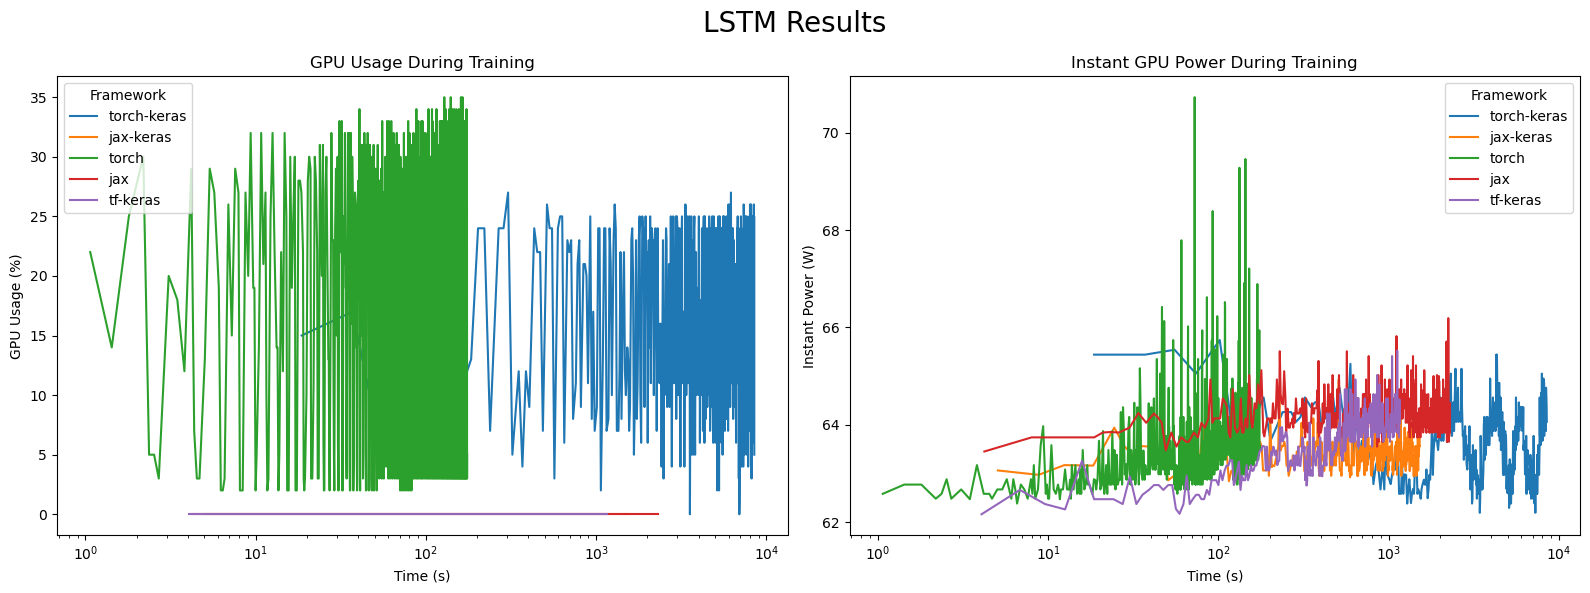

In [9]:
show_plots("lstm")

In [10]:
rows = []

for model, libraries in results.items():
    for framework, precisions in libraries.items():
        for precision, seeds in precisions.items():
            for seed, data in seeds.items():
                if "train_samples" in data:
                    df = data["train_samples"]

                    row = {
                        "model": model,
                        "framework": framework,
                        "precision": precision,
                        "mean_gpu_utilization": df["gpu_2_utilization"].mean(),
                        "max_gpu_memory_used": df["gpu_2_memory_used"].max()
                    }

                    rows.append(row)


result_df = pd.DataFrame(rows)

# Group by model, framework and precision, with seed mean
metrics_df = result_df.groupby(["model", "framework", "precision"], as_index=False).agg({
    "mean_gpu_utilization": "mean",
    "max_gpu_memory_used": "mean"
})


In [11]:
metrics_df.shape

(68, 5)

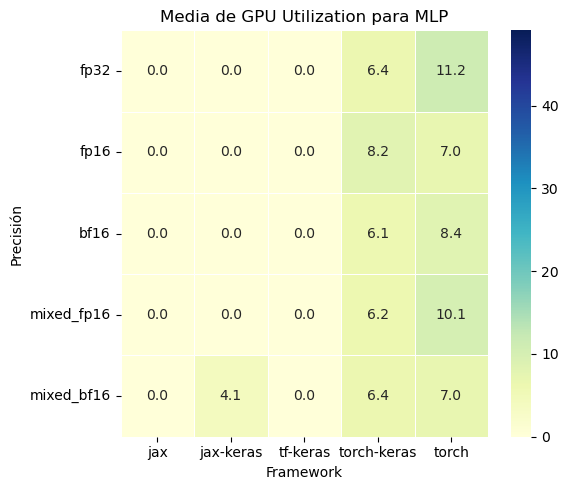

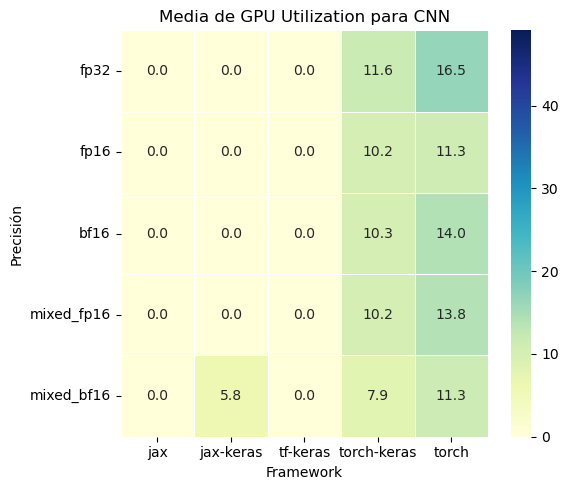

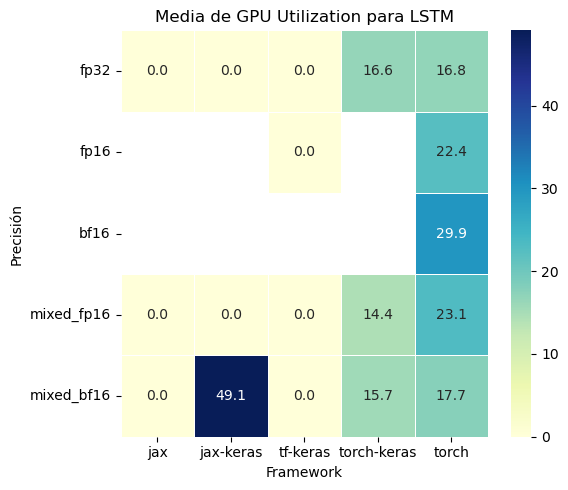

In [12]:
vmin = metrics_df["mean_gpu_utilization"].min()
vmax = metrics_df["mean_gpu_utilization"].max()

# Crear figura y ejes

for model in model_order:
    subset = metrics_df[metrics_df["model"] == model]

    # Pivotamos: filas = framework, columnas = precision
    pivot = subset.pivot_table(
        index="precision",
        columns="framework",
        values="mean_gpu_utilization"
    )

    # Reordenamos filas y columnas según tus listas
    pivot = pivot.reindex(index=precision_order, columns=backend_order)

    # Creamos el heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        linewidths=.5
    )
    plt.title(f"Media de GPU Utilization para {model.upper()}")
    plt.xlabel("Framework")
    plt.ylabel("Precisión")
    plt.tight_layout()
    plt.show()

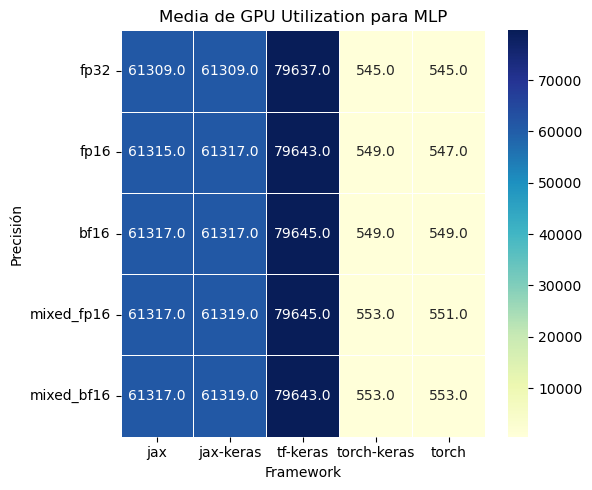

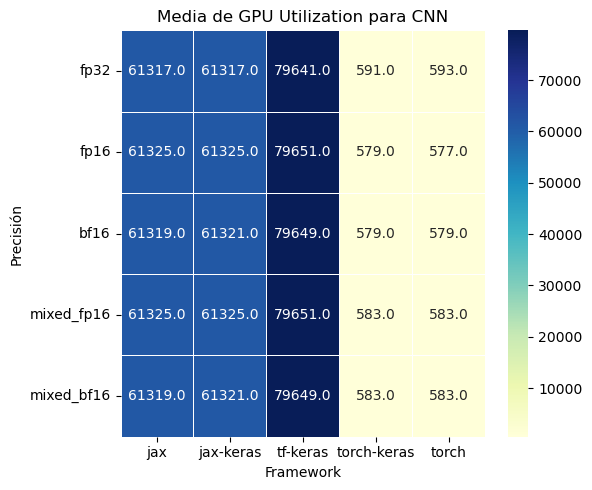

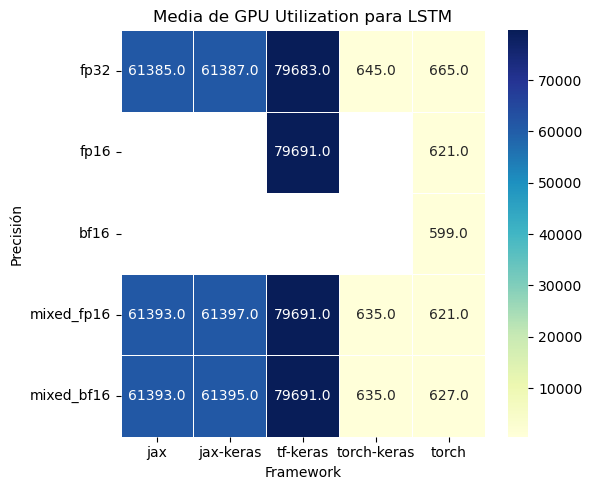

In [13]:
vmin = metrics_df["max_gpu_memory_used"].min()
vmax = metrics_df["max_gpu_memory_used"].max()

# Crear figura y ejes

for model in model_order:
    subset = metrics_df[metrics_df["model"] == model]

    # Pivotamos: filas = framework, columnas = precision
    pivot = subset.pivot_table(
        index="precision",
        columns="framework",
        values="max_gpu_memory_used"
    )

    # Reordenamos filas y columnas según tus listas
    pivot = pivot.reindex(index=precision_order, columns=backend_order)

    # Creamos el heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        linewidths=.5
    )
    plt.title(f"Media de GPU Utilization para {model.upper()}")
    plt.xlabel("Framework")
    plt.ylabel("Precisión")
    plt.tight_layout()
    plt.show()

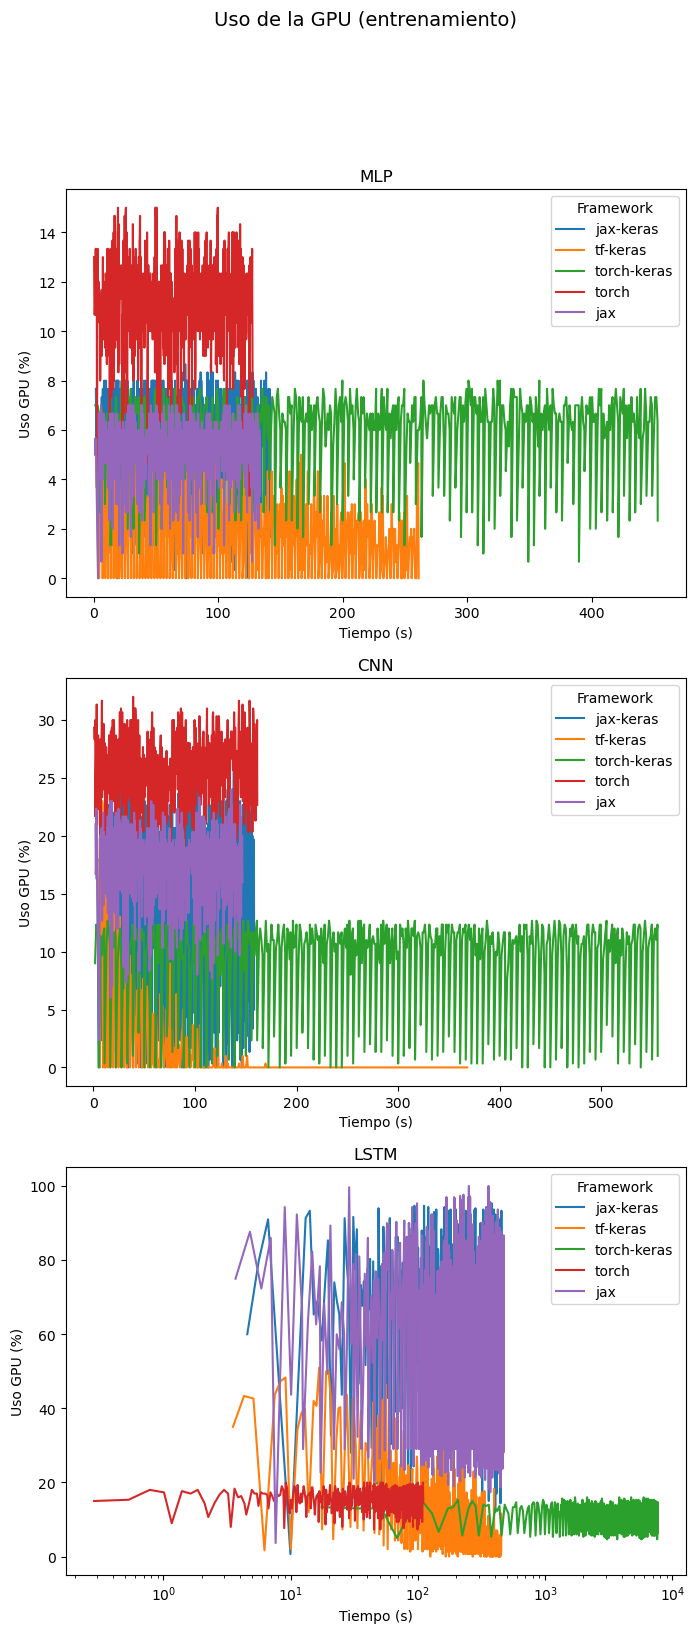

In [ ]:
   
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

fig.suptitle("Uso de la GPU (entrenamiento)", fontsize=14)

for i, model in enumerate(resultados):
    ax = axes[i]
    for framework in librerias:
        train_samples_df = get_mean_df(resultados[model][framework], "train_samples")
        
        # Gráfico 1: GPU Utilization vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_utilization", ax=ax, label=framework)
        
        # Gráfico 3: GPU Power vs Timestamp
        #sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_power", ax=ax, label=libreria)


    # Configuración de títulos y etiquetas
    ax.set_title(model.upper())
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Uso GPU (%)")

#axes[1].set_title("Consumo instantáneo de la GPU (entrenamiento)")
#axes[1].set_xlabel("Tiempo (s)")
#axes[1].set_ylabel("Consumo instantáneo (W)")

# Agregar leyendas
    ax.legend(title="Framework")
    if model == "lstm":
        if i < 3:
            ax.set(xscale="log")
        else:
            ax.set(yscale="log")

# Mostrar la figura
plt.show()

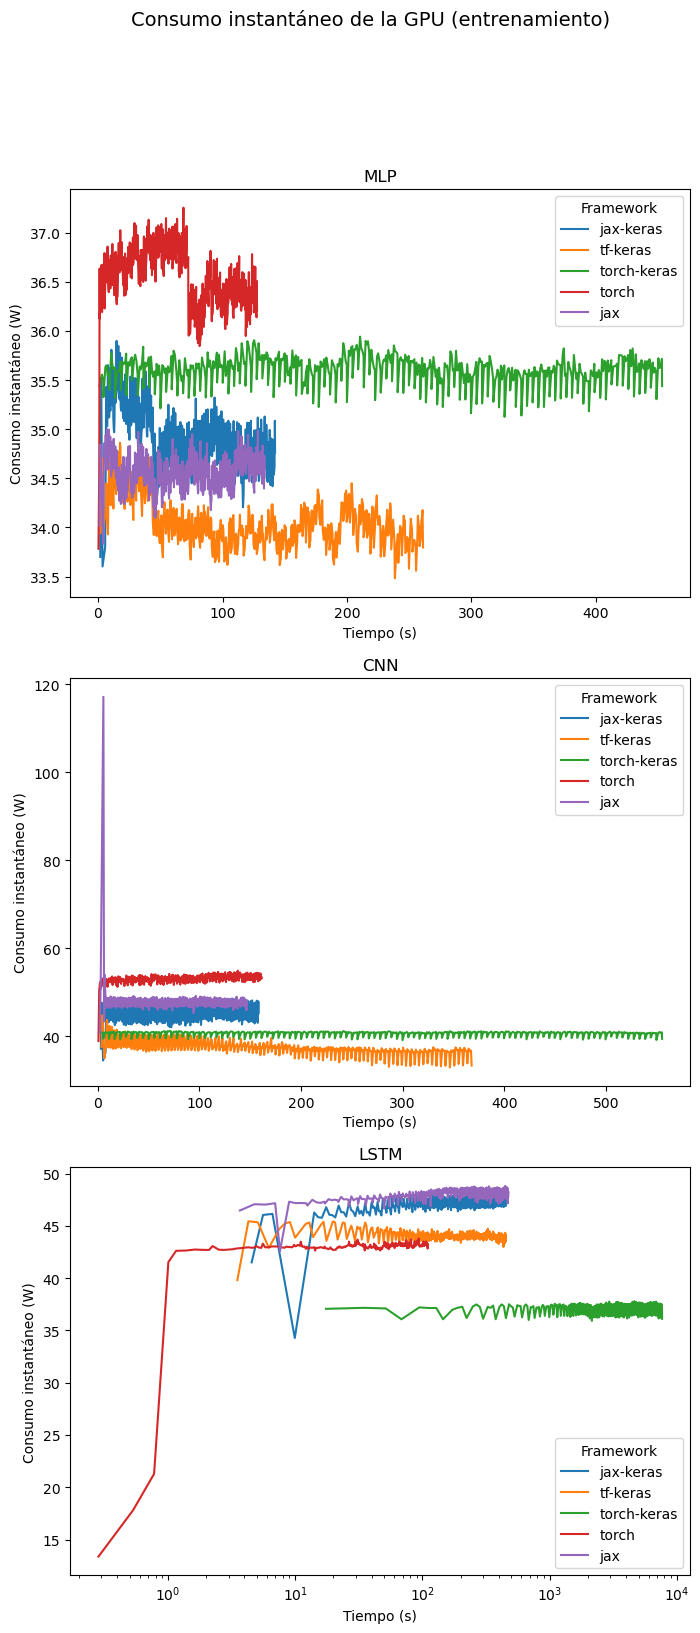

In [ ]:
   
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

fig.suptitle("Consumo instantáneo de la GPU (entrenamiento)", fontsize=14)

for i, model in enumerate(resultados):
    ax = axes[i]
    for framework in librerias:
        train_samples_df = get_mean_df(resultados[model][framework], "train_samples")
        
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_power", ax=ax, label=framework)


    # Configuración de títulos y etiquetas
    ax.set_title(model.upper())
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Consumo instantáneo (W)")

# Agregar leyendas
    ax.legend(title="Framework")
    if model == "lstm":
        if i < 3:
            ax.set(xscale="log")
        else:
            ax.set(yscale="log")

# Mostrar la figura
plt.show()

/tmp/ipykernel_1623099/2026235316.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


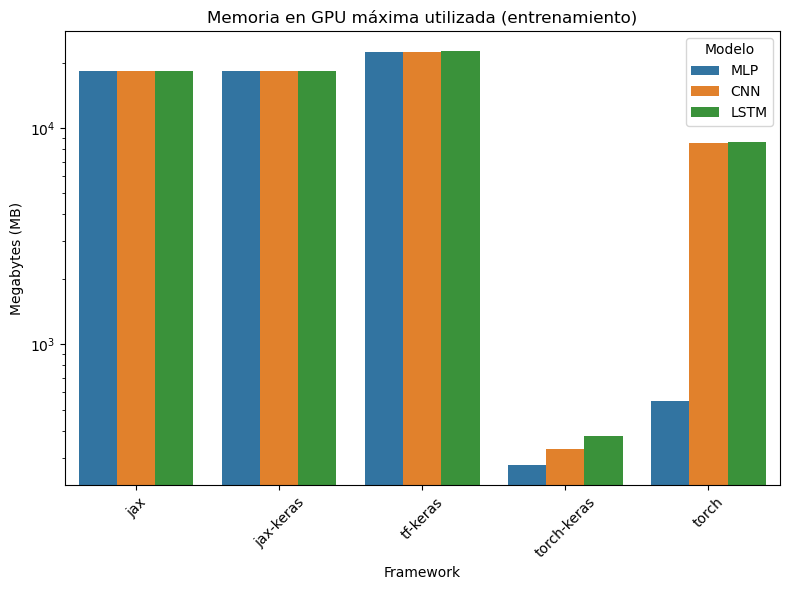

In [ ]:
memory_dfs = []

for model, librerias in resultados.items():
    for framework, semillas in librerias.items():
        for semilla, datos in semillas.items():
            
            if "train_samples" in datos:
                train_samples_df = datos["train_samples"].copy()
                df = pd.DataFrame({
                    "model_type": [model],
                    "framework": [framework],
                    "memory_used": [train_samples_df["gpu_0_memory_used"].max()]
                })
                memory_dfs.append(df)
                
memory_df = pd.concat(memory_dfs, ignore_index=True)


fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=memory_df,
    x="framework",
    y="memory_used",
    hue="model_type",
    hue_order=orden,
    ax=ax
)

ax.set_title("Memoria en GPU máxima utilizada (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Megabytes (MB)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

In [14]:
df_combined = pd.merge(
    metrics_df,
    global_metrics_df,
    left_on=['framework', 'model', 'precision'],
    right_on=['backend', 'model_type', 'precision']
)
df_combined.drop(columns=['backend', 'model_type'], inplace=True)

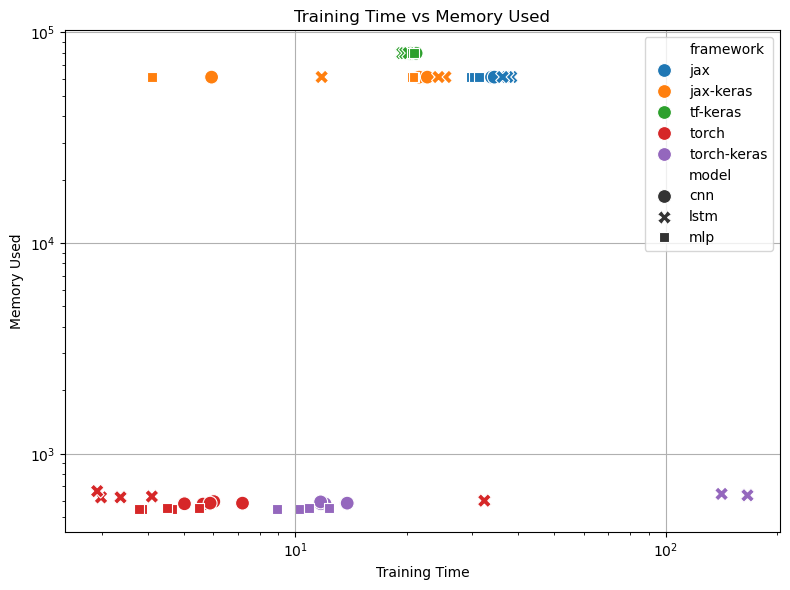

In [15]:
# 2. Crear el gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_combined,
    x='training_time',
    y='max_gpu_memory_used',
    hue='framework',
    style='model',
    s=100 # tamaño de los puntos
)
plt.title('Training Time vs Memory Used')
plt.xlabel('Training Time')
plt.ylabel('Memory Used')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

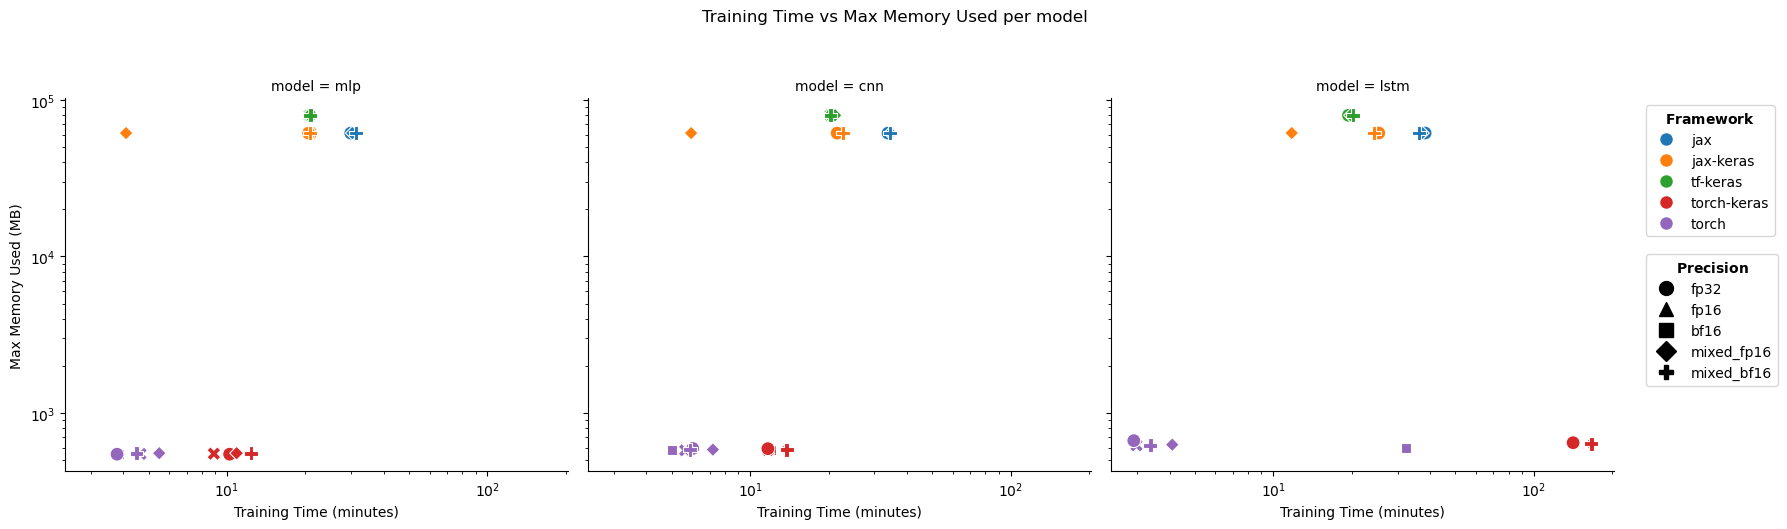

In [53]:
from matplotlib.lines import Line2D


g = sns.FacetGrid(
    df_combined,#[pd.isna(global_metrics_df['test_loss']) == False],
    col="model",
    col_order=model_order,
    height=5,
    aspect=1.2
)

# Dibujar el scatterplot en cada panel
g.map_dataframe(
    sns.scatterplot,
    x="training_time",
    y="max_gpu_memory_used",
    hue="framework",
    hue_order=backend_order,
    style="precision",
    style_order=precision_order,
    s=100
)

# Ajustes del gráfico
g.set(xscale="log", yscale="log")
g.set_axis_labels("Training Time (minutes)", "Max Memory Used (MB)")
g.figure.suptitle("Training Time vs Max Memory Used per model", y=1.05)

# Extraer listas únicas ordenadas según las listas que diste
frameworks = [fw for fw in backend_order if fw in df_combined['framework'].unique()]
precisions = [p for p in precision_order if p in df_combined['precision'].unique()]

# Crear handles personalizados
colors = sns.color_palette(n_colors=len(frameworks))
framework_handles = [
    Line2D([0], [0], marker='o', color='w', label=fw, markerfacecolor=colors[i], markersize=10)
    for i, fw in enumerate(frameworks)
]

precision_styles = {
    "fp32": "o",
    "bf16": "s",
    "fp16": "^",
    "mixed_fp16": "D",
    "mixed_bf16": "P"
}
precision_handles = [
    Line2D([0], [0], marker=precision_styles.get(p, 'o'), color='black', linestyle='None', label=p, markersize=10)
    for p in precisions
]

# Usamos el primer eje de la grilla
first_ax = g.axes.flat[-1]  # forma segura para cualquier grilla

# Leyenda de frameworks
legend1 = first_ax.legend(handles=framework_handles, title=r"$\bf{Framework}$", loc='upper left', bbox_to_anchor=(1.05, 1))
first_ax.add_artist(legend1)

# Línea divisoria (opcional)
first_ax.plot([1.02, 1.23], [0.78, 0.78], transform=first_ax.transAxes, color='gray', linewidth=1)

# Leyenda de precisiones
legend2 = first_ax.legend(handles=precision_handles, title=r"$\bf{Precision}$", loc='upper left', bbox_to_anchor=(1.05, 0.6))

plt.tight_layout()
plt.show()

In [18]:
global_metrics_df["total_time"] = global_metrics_df["training_time"] * 60 + global_metrics_df["testing_time"]
total_time = global_metrics_df["total_time"].sum() / 3600

In [19]:
print(f"One seed: {total_time:.2f}h")
print(f"Two seeds: {2*total_time:.2f}h")
print(f"Days (12h/day): {2*total_time/12:.2f} days")

One seed: 27.64h
Two seeds: 55.28h
Days (12h/day): 4.61 days


In [20]:
# Julios = vatios * segundos
energia_total = []

for model in results:
    for framework in results[model]:
        for precision in results[model][framework]:
            if "train_samples" in results[model][framework][precision]["42"]:
                train_samples_df = results[model][framework][precision]["42"]["train_samples"]

                # Ordenar por timestamp
                train_samples_df = train_samples_df.sort_values(by="timestamp").reset_index(drop=True)

                # Calcular delta_t (diferencia de tiempo entre muestras en segundos)
                train_samples_df["delta_t"] = train_samples_df["timestamp"].diff().fillna(0)

                # Calcular la energía consumida en cada intervalo (P * delta_t)
                train_samples_df["energy"] = train_samples_df["gpu_2_power"] * train_samples_df["delta_t"]

                # Sumar toda la energía consumida
                energia_total.append({
                    "model": model,
                    "framework": framework,
                    "precision": precision,
                    "energy": train_samples_df["energy"].sum() / (1000 * 3600) # pasar de J a KWh
                })

energy_df = pd.DataFrame(energia_total)

In [21]:
energy_df.head(5) # It could be done in metrics_df

,model,framework,precision,energy
0,cnn,torch-keras,mixed_bf16,0.014757
1,cnn,torch-keras,fp32,0.012422
2,cnn,torch-keras,bf16,0.012996
3,cnn,torch-keras,mixed_fp16,0.014630
4,cnn,torch-keras,fp16,0.012464


/tmp/ipykernel_590915/2043491592.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/2043491592.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/2043491592.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


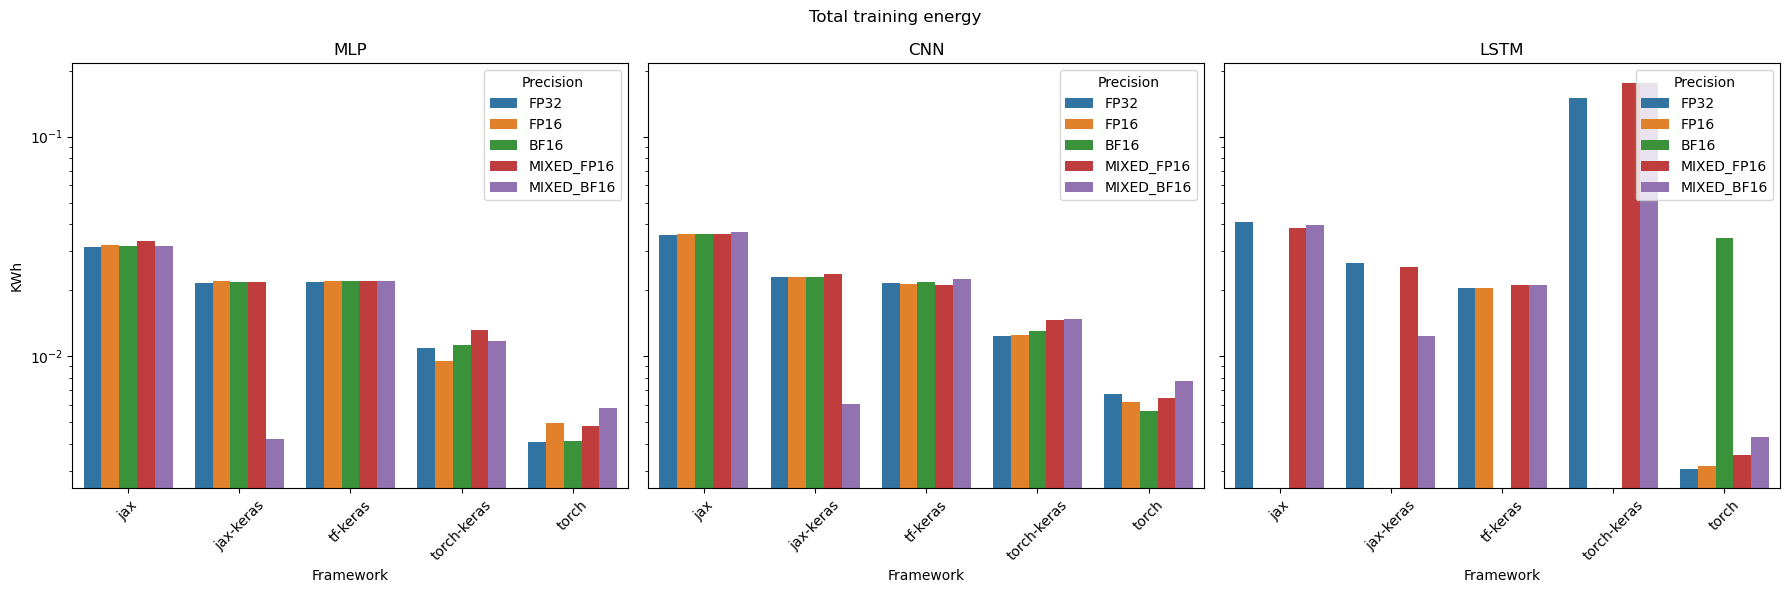

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Total training energy")

for i, model in enumerate(model_order):
    ax = axes[i]
    model_df = energy_df[energy_df["model"] == model]
    
    sns.barplot(
        data=model_df,#[pd.isna(model_df["test_loss"]) == False],
        x="framework",
        y="energy",
        hue="precision",
        order=backend_order,
        hue_order=precision_order,
        ax=ax
    )
    
    ax.set_title(model.upper())
    ax.set_xlabel("Framework")
    ax.set_ylabel("KWh" if i == 0 else "")  # Only show y-label on the first plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set(yscale="log")

    legend = ax.legend(title='Precision', loc='upper right')
    for label in legend.get_texts():
        label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

In [25]:
energy_df = pd.merge(
    energy_df,
    global_metrics_df,
    left_on=['framework', 'model', 'precision'],
    right_on=['backend', 'model_type', 'precision']
)
energy_df.drop(columns=['backend', 'model_type'], inplace=True)

energy_df["energy_per_hour"] = energy_df["energy"] / energy_df["training_time"] * 60 # time is in minutes

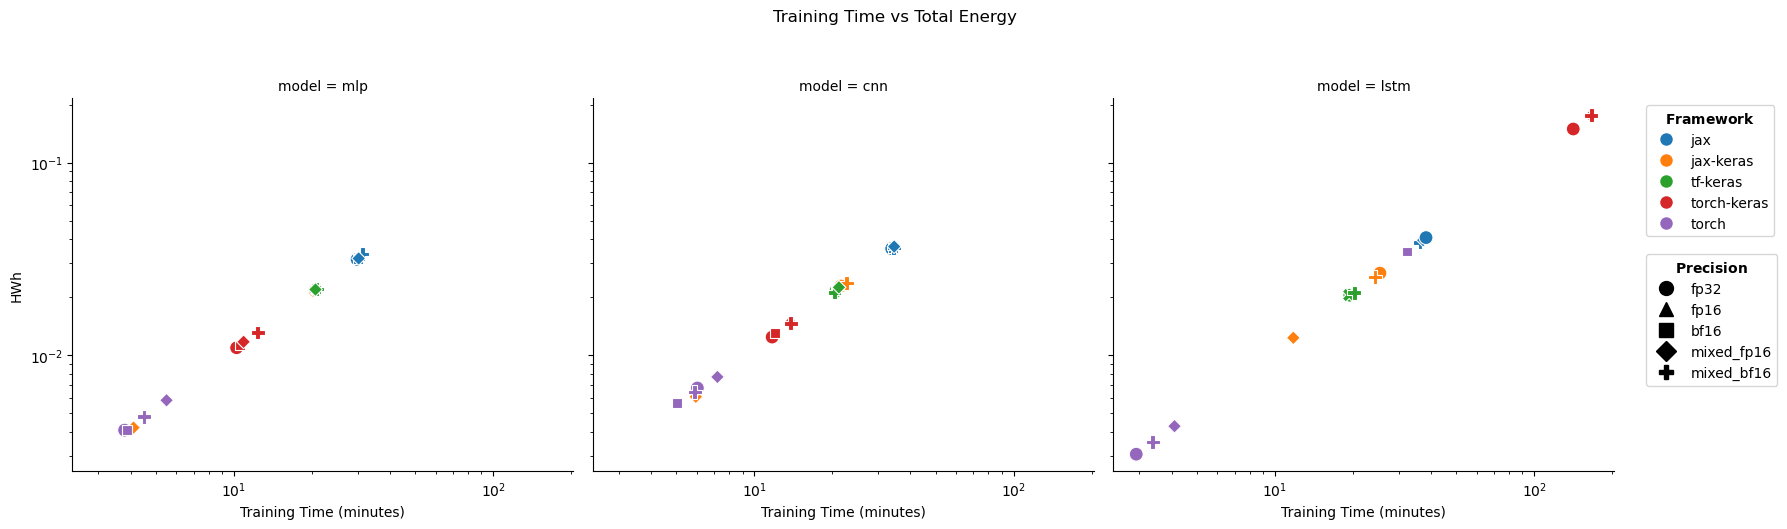

In [28]:
g = sns.FacetGrid(
    energy_df[pd.isna(global_metrics_df['test_loss']) == False],
    col="model",
    col_order=model_order,
    height=5,
    aspect=1.2
)

# Dibujar el scatterplot en cada panel
g.map_dataframe(
    sns.scatterplot,
    x="training_time",
    y="energy",
    hue="framework",
    hue_order=backend_order,
    style="precision",
    style_order=precision_order,
    s=100
)

# Ajustes del gráfico
g.set(xscale="log", yscale="log")
g.set_axis_labels("Training Time (minutes)", "HWh")
g.figure.suptitle("Training Time vs Total Energy", y=1.05)

# Extraer listas únicas ordenadas según las listas que diste
frameworks = [fw for fw in backend_order if fw in df_combined['framework'].unique()]
precisions = [p for p in precision_order if p in df_combined['precision'].unique()]

# Crear handles personalizados
colors = sns.color_palette(n_colors=len(frameworks))
framework_handles = [
    Line2D([0], [0], marker='o', color='w', label=fw, markerfacecolor=colors[i], markersize=10)
    for i, fw in enumerate(frameworks)
]

precision_styles = {
    "fp32": "o",
    "bf16": "s",
    "fp16": "^",
    "mixed_fp16": "D",
    "mixed_bf16": "P"
}
precision_handles = [
    Line2D([0], [0], marker=precision_styles.get(p, 'o'), color='black', linestyle='None', label=p, markersize=10)
    for p in precisions
]

# Usamos el primer eje de la grilla
first_ax = g.axes.flat[-1]  # forma segura para cualquier grilla

# Leyenda de frameworks
legend1 = first_ax.legend(handles=framework_handles, title=r"$\bf{Framework}$", loc='upper left', bbox_to_anchor=(1.05, 1))
first_ax.add_artist(legend1)

# Línea divisoria (opcional)
first_ax.plot([1.02, 1.23], [0.78, 0.78], transform=first_ax.transAxes, color='gray', linewidth=1)

# Leyenda de precisiones
legend2 = first_ax.legend(handles=precision_handles, title=r"$\bf{Precision}$", loc='upper left', bbox_to_anchor=(1.05, 0.6))

plt.tight_layout()
plt.show()

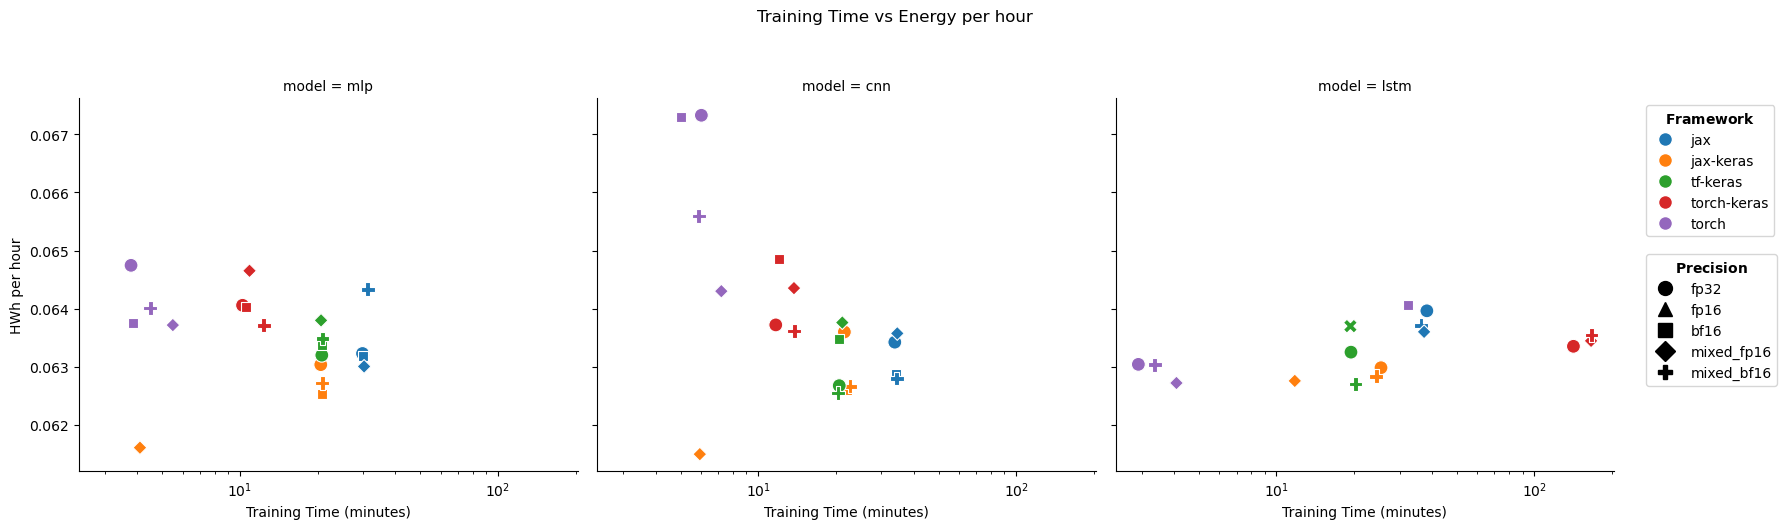

In [29]:
g = sns.FacetGrid(
    energy_df[pd.isna(global_metrics_df['test_loss']) == False],
    col="model",
    col_order=model_order,
    height=5,
    aspect=1.2
)

# Dibujar el scatterplot en cada panel
g.map_dataframe(
    sns.scatterplot,
    x="training_time",
    y="energy_per_hour",
    hue="framework",
    hue_order=backend_order,
    style="precision",
    style_order=precision_order,
    s=100
)

# Ajustes del gráfico
g.set(xscale="log")
g.set_axis_labels("Training Time (minutes)", "HWh per hour")
g.figure.suptitle("Training Time vs Energy per hour", y=1.05)

# Extraer listas únicas ordenadas según las listas que diste
frameworks = [fw for fw in backend_order if fw in df_combined['framework'].unique()]
precisions = [p for p in precision_order if p in df_combined['precision'].unique()]

# Crear handles personalizados
colors = sns.color_palette(n_colors=len(frameworks))
framework_handles = [
    Line2D([0], [0], marker='o', color='w', label=fw, markerfacecolor=colors[i], markersize=10)
    for i, fw in enumerate(frameworks)
]

precision_styles = {
    "fp32": "o",
    "bf16": "s",
    "fp16": "^",
    "mixed_fp16": "D",
    "mixed_bf16": "P"
}
precision_handles = [
    Line2D([0], [0], marker=precision_styles.get(p, 'o'), color='black', linestyle='None', label=p, markersize=10)
    for p in precisions
]

# Usamos el primer eje de la grilla
first_ax = g.axes.flat[-1]  # forma segura para cualquier grilla

# Leyenda de frameworks
legend1 = first_ax.legend(handles=framework_handles, title=r"$\bf{Framework}$", loc='upper left', bbox_to_anchor=(1.05, 1))
first_ax.add_artist(legend1)

# Línea divisoria (opcional)
first_ax.plot([1.02, 1.23], [0.78, 0.78], transform=first_ax.transAxes, color='gray', linewidth=1)

# Leyenda de precisiones
legend2 = first_ax.legend(handles=precision_handles, title=r"$\bf{Precision}$", loc='upper left', bbox_to_anchor=(1.05, 0.6))

plt.tight_layout()
plt.show()

/tmp/ipykernel_590915/593662609.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/593662609.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/593662609.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


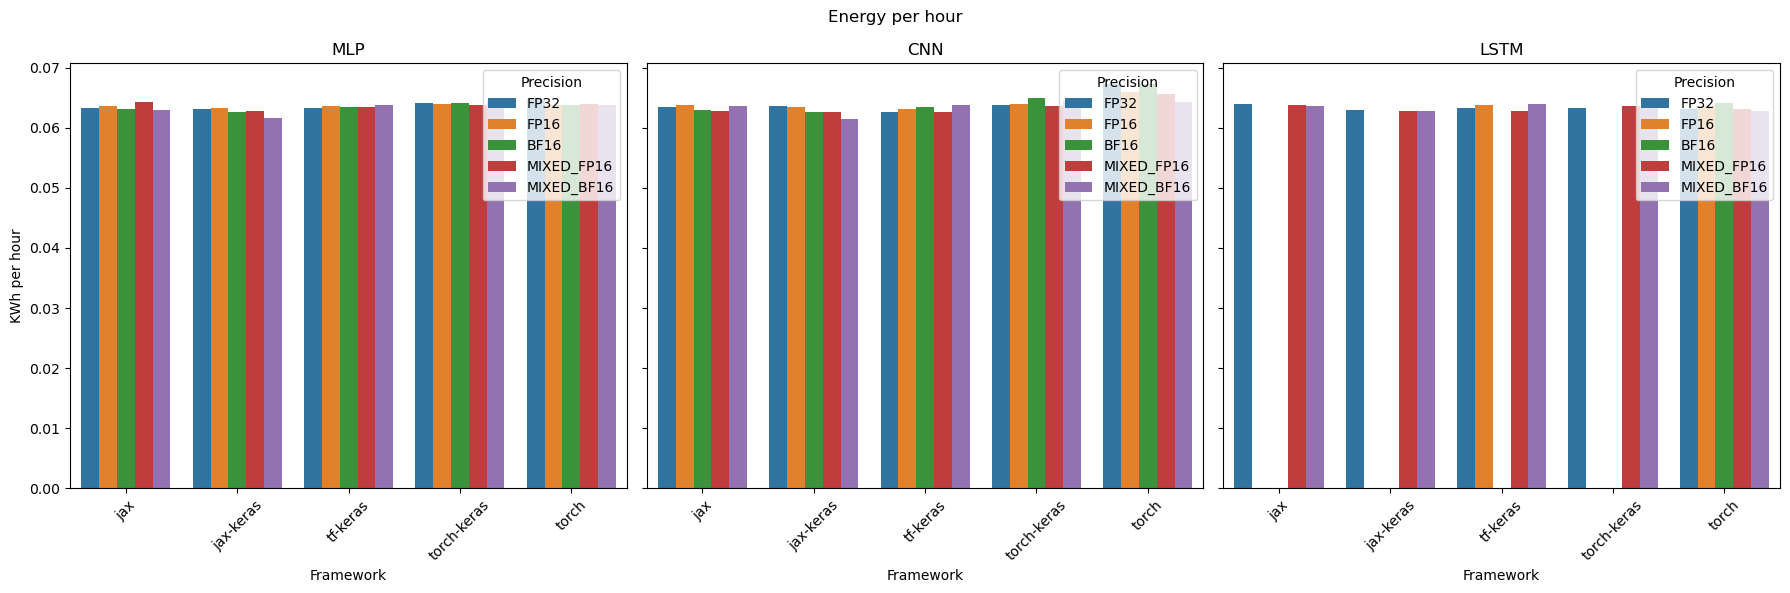

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Energy per hour")

for i, model in enumerate(model_order):
    ax = axes[i]
    model_df = energy_df[energy_df["model"] == model]
    
    sns.barplot(
        data=model_df,#[pd.isna(model_df["test_loss"]) == False],
        x="framework",
        y="energy_per_hour",
        hue="precision",
        order=backend_order,
        hue_order=precision_order,
        ax=ax
    )
    
    ax.set_title(model.upper())
    ax.set_xlabel("Framework")
    ax.set_ylabel("KWh per hour" if i == 0 else "")  # Only show y-label on the first plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #ax.set(yscale="log")

    legend = ax.legend(title='Precision', loc='upper right')
    for label in legend.get_texts():
        label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

In [ ]:

all_test_results = []

for model in results:
    for framework in results[model]:
        for precision in results[model][framework]:
            if "test" in results[model][framework][precision]["42"]:
                test_df = results[model][framework][precision]["42"]["test"]
                test_df["model"] = model
                test_df["framework"] = framework
                test_df["precision"] = precision
                all_test_results.append(test_df)

test_results_df = pd.concat(all_test_results, ignore_index=True)

In [ ]:
test_results_df.head(20)

,accuracy,loss,epoch_time,model,framework,precision,mae
0,0.744300,0.765928,1.900938,cnn,torch-keras,mixed_bf16,NaN
1,0.746700,0.772665,1.338965,cnn,torch-keras,fp32,NaN
2,0.098500,2.310117,1.369076,cnn,torch-keras,bf16,NaN
3,0.744100,0.778178,1.375102,cnn,torch-keras,mixed_fp16,NaN
4,0.100000,NaN,1.316809,cnn,torch-keras,fp16,NaN
5,0.743500,0.765169,1.172025,cnn,jax-keras,mixed_bf16,NaN
6,0.100000,NaN,9.243503,cnn,jax-keras,fp16,NaN
7,0.738700,0.791951,9.018305,cnn,jax-keras,fp32,NaN
8,0.098600,2.302622,9.298016,cnn,jax-keras,bf16,NaN
9,0.738300,0.774521,9.747347,cnn,jax-keras,mixed_fp16,NaN


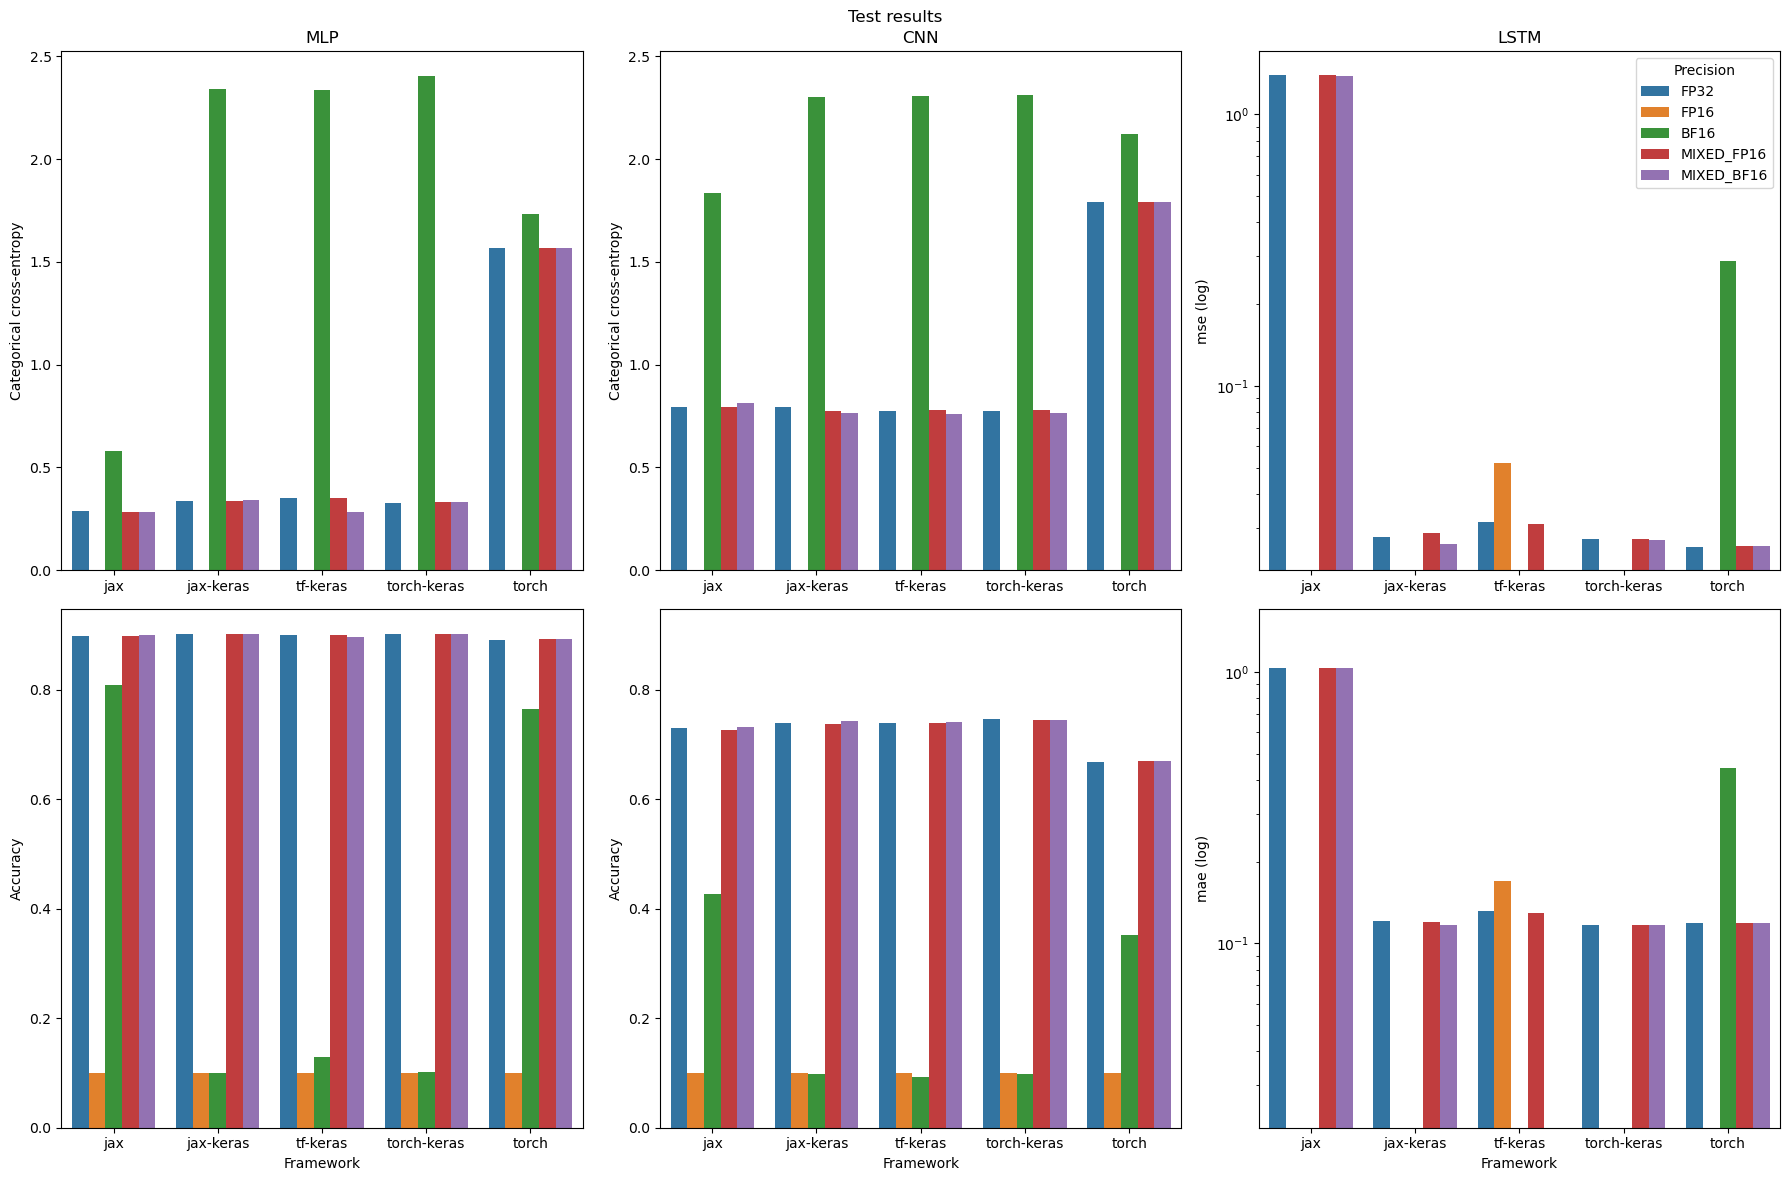

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Test results")

# Compartir eje Y en la primera fila
axes[0][1].sharey(axes[0][0])

axes[1][1].sharey(axes[1][0])

axes[1][2].sharey(axes[0][2])


for i, model in enumerate(model_order):
    model_df = test_results_df[test_results_df["model"] == model]
    
    ax = axes[0, i]
    
    sns.barplot(
        data=model_df,#[pd.isna(model_df["test_loss"]) == False],
        x="framework",
        y="loss",
        hue="precision",
        order=backend_order,
        hue_order=precision_order,
        ax=ax
    )
    
    ax.set_title(model.upper())
    ax.set_xlabel("")
    ax.set_ylabel("Categorical cross-entropy" if model != "lstm" else "mse (log)")
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


    if (model == "lstm"):
        ax.set(yscale="log")
        legend = ax.legend(title='Precision', loc='upper right')
        for label in legend.get_texts():
            label.set_text(label.get_text().upper())
    else:
        ax.legend().set_visible(False)
    
    

    ax = axes[1, i]

    sns.barplot(
        data=model_df,#[pd.isna(model_df["test_loss"]) == False],
        x="framework",
        y="accuracy" if model != "lstm" else "mae",
        hue="precision",
        order=backend_order,
        hue_order=precision_order,
        ax=ax
    )
    
    ax.set_xlabel("Framework")
    ax.set_ylabel("Accuracy" if model != "lstm" else "mae (log)")
    ax.legend().set_visible(False)

    if (model == "lstm"):
        ax.set(yscale="log")


plt.tight_layout()
plt.show()

In [47]:

# Julios = vatios * segundos
energia_total = []

for model in resultados:
    for framework in resultados[model]:
        train_samples_df = get_mean_df(resultados[model][framework], "train_samples")

        # Ordenar por timestamp (por si acaso no lo estuviesen)
        train_samples_df = train_samples_df.sort_values(by="timestamp").reset_index(drop=True)

        # Calcular delta_t (diferencia de tiempo entre muestras en segundos)
        train_samples_df["delta_t"] = train_samples_df["timestamp"].diff().fillna(0)

        # Calcular la energía consumida en cada intervalo (P * delta_t)
        train_samples_df["energia"] = train_samples_df["gpu_0_power"] * train_samples_df["delta_t"]

        # Sumar toda la energía consumida
        energia_total.append({
            "modelo": model,
            "libreria": framework,
            "energia": train_samples_df["energia"].sum() / (1000 * 3600) # pasar de J a KWh
        })

df_energia = pd.DataFrame(energia_total)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_energia,
    x="libreria",
    y="energia",
    hue="modelo",
    ax=ax
)

ax.set_title("Energía total consumida (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Energía (KWh)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()


NameError: name 'resultados' is not defined

/tmp/ipykernel_1580103/3297175451.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


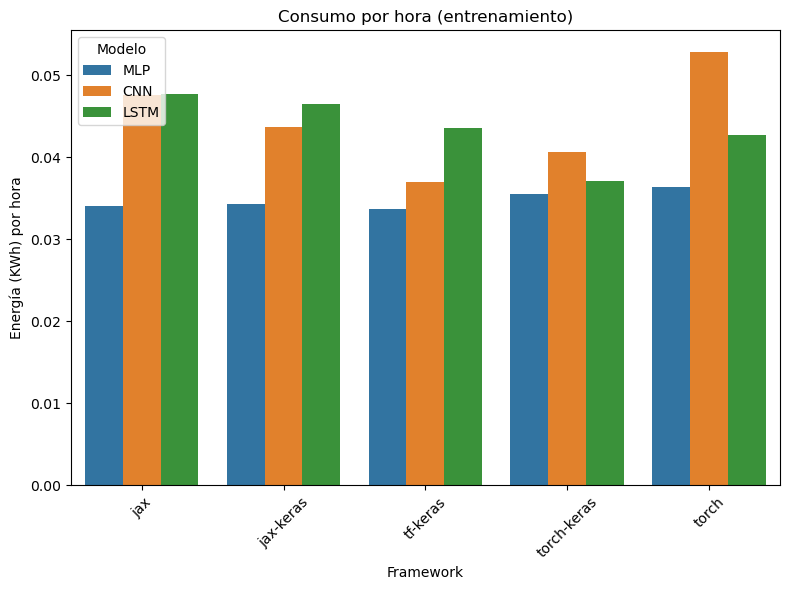

In [ ]:

# Julios = vatios * segundos
energia_total = []

for model in resultados:
    for framework in resultados[model]:
        train_samples_df = get_mean_df(resultados[model][framework], "train_samples")

        # Ordenar por timestamp (por si acaso no lo estuviesen)
        train_samples_df = train_samples_df.sort_values(by="timestamp").reset_index(drop=True)

        # Calcular delta_t (diferencia de tiempo entre muestras en segundos)
        train_samples_df["delta_t"] = train_samples_df["timestamp"].diff().fillna(0)

        # Calcular la energía consumida en cada intervalo (P * delta_t)
        train_samples_df["energia"] = train_samples_df["gpu_0_power"] * train_samples_df["delta_t"]

        # Tiempo de entrenamiento
        tiempos = []
        for semilla in resultados[model][framework]:
            tiempos.append(resultados[model][framework][semilla]["global_metrics"]["training_time"])

        tiempo = np.mean(tiempos)

        # Sumar toda la energía consumida
        energia_total.append({
            "modelo": model,
            "libreria": framework,
            "energia": (train_samples_df["energia"].sum() / (1000)) / tiempo
        })

df_energia = pd.DataFrame(energia_total)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_energia,
    x="libreria",
    y="energia",
    hue="modelo",
    ax=ax
)

ax.set_title("Consumo por hora (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Energía (KWh) por hora")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#a

legend = ax.legend(title='Modelo', loc='upper left' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()


/tmp/ipykernel_590915/687757100.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_590915/687757100.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


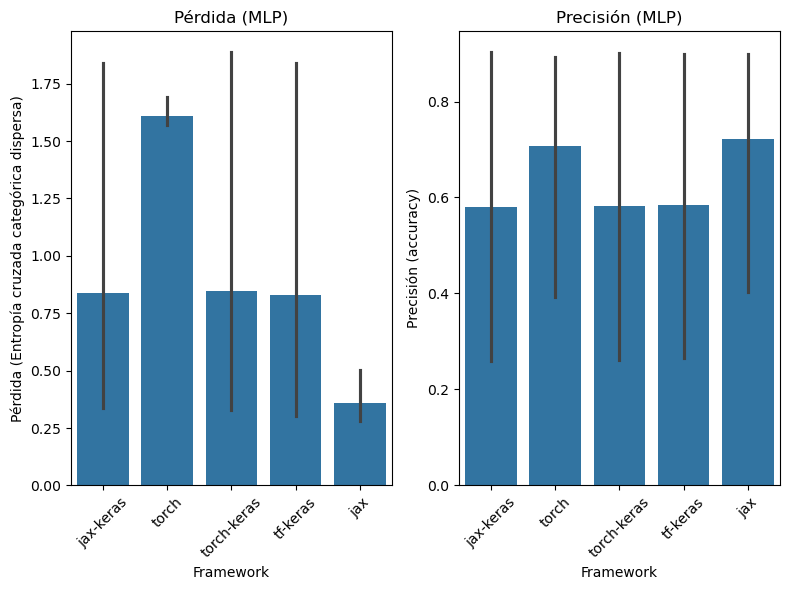

In [36]:

df = test_results_df[test_results_df["model"] == "mlp"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model",
    ax=axes[0]
)

axes[0].set_title("Pérdida (MLP)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (Entropía cruzada categórica dispersa)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="accuracy",
    hue="model",
    ax=axes[1]
)

axes[1].set_title(f"Precisión (MLP)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("Precisión (accuracy)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1580103/2124072207.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1580103/2124072207.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


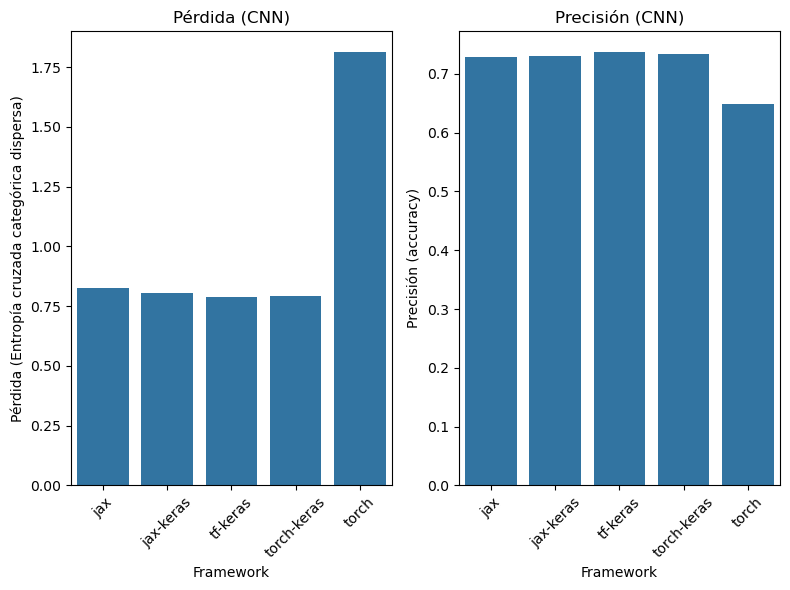

In [23]:

df = test_results_df[test_results_df["model_type"] == "cnn"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model_type",
    ax=axes[0]
)

axes[0].set_title("Pérdida (CNN)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (Entropía cruzada categórica dispersa)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="accuracy",
    hue="model_type",
    ax=axes[1]
)

axes[1].set_title(f"Precisión (CNN)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("Precisión (accuracy)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1580103/1385529771.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1580103/1385529771.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


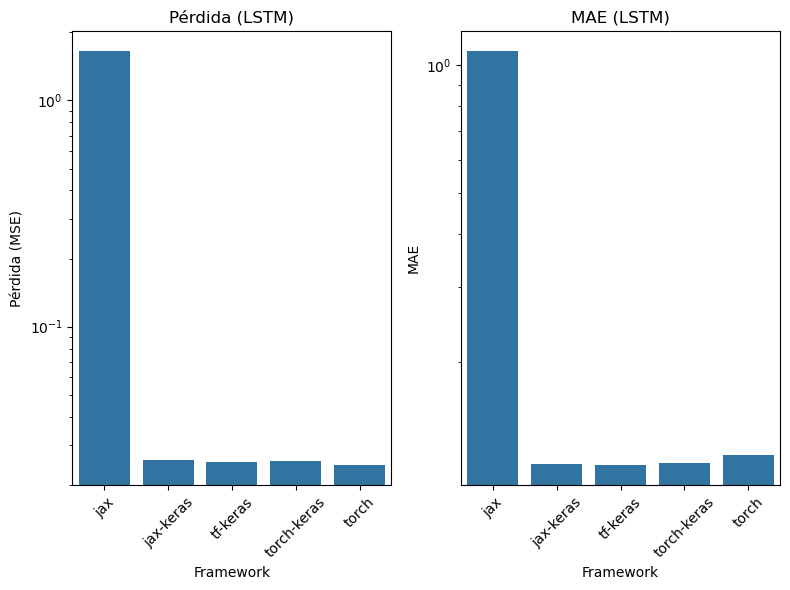

In [24]:

df = test_results_df[test_results_df["model_type"] == "lstm"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model_type",
    order=["jax", "jax-keras", "tf-keras", "torch-keras", "torch"],
    ax=axes[0]
)

axes[0].set_title("Pérdida (LSTM)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (MSE)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="mae",
    hue="model_type",
    order=["jax", "jax-keras", "tf-keras", "torch-keras", "torch"],
    ax=axes[1]
)

axes[1].set_title("MAE (LSTM)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("MAE")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)
    ax.set(yscale="log")

plt.tight_layout()
plt.show()